<a href="https://colab.research.google.com/github/kobemawu/www/blob/master/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 課題2: 以下の要件を満たすプログラムを作成
- 課題1で使用した文書のトピックについて分析をお子kナウ
- トピックモデルLDA(Latent Dirichlet Allocation)を利用

## 必要なライブラリ・データセットのインポート

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import collections

nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /home/junya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/junya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### 百人一首のデータを読み込み

In [2]:
import glob
import os
import re

# Ogura Hyakunin Isshu
DATA_PATH = './100poets/100poets.txt'

def cleaning_text(text):
    # remove ".,!?:;" 
    pattern1 = '[,.!\?;:]'
    text = re.sub(pattern1, '', text)    
    # remove "--"
    pattern2 = '--'
    text = re.sub(pattern2, '', text)    
    # remove "\n"
    pattern3 = '\\n'
    text = re.sub(pattern3, '', text)    
    return text

# read file and set docs
f = open(DATA_PATH)
docs=[cleaning_text(line).split() for line in f]
f.seek(0, os.SEEK_SET)
org=[cleaning_text(line) for line in f]
f.close()

#print(docs[:1])
#print(org[:1])
print("num of docs:", len(docs))

num of docs: 100


## 最適なトピック数を求めるため

In [3]:
# calculate perplexity and coherence
def compute_metrics(model, texts, corpus, dct):
    pp = np.exp2(-model.log_perplexity(corpus))
 
    cm = CoherenceModel(model=model, texts=texts, dictionary=dct, coherence='u_mass')
    ch = cm.get_coherence()
 
    return pp, ch

## 前処理

In [4]:
# create stop word list
en_stop = nltk.corpus.stopwords.words('english')

# add additional stop word
en_stop= ["``","/",",.",".,",";","--",":",")","(",'"','&',"'",'),',',"','-','.,','.,"','.-',"?",">","<"] \
         + ["0","1","2","3","4","5","6","7","8","9"] \
         + en_stop

# create preprocessing function
from nltk.corpus import wordnet as wn #lemmatize関数のためのimport

def preprocess_word(word, stopwordset):
    
    #1.make words lower ex: Python =>python
    word=word.lower()
    
    #2.remove "," and "."
    if word in [",","."]:
        return None
    
    #3.remove stopword  ex: the => (None) 
    if word in stopwordset:
        return None
    
    #4.lemmatize  ex: cooked=>cook
    lemma = wn.morphy(word)
    if lemma is None:
        return word

    elif lemma in stopwordset: #lemmatizeしたものがstopwordである可能性がある
        return None
    else:
        return lemma    

def preprocess_document(document):
    document=[preprocess_word(w, en_stop) for w in document]
    document=[w for w in document if w is not None]
    return document

def preprocess_documents(documents):
    return [preprocess_document(document) for document in documents]

# preprocessing
pre_docs = preprocess_documents(docs)

#print(pre_docs[0]) # for debug

## LDA準備

In [5]:
import gensim
from gensim import corpora

#documentを，gensim LDAが読み込めるデータ構造にする

pro_docs = preprocess_documents(docs)

# create dictionary
dictionary = corpora.Dictionary(pro_docs)
# create corpus
corpus_ = [dictionary.doc2bow(doc) for doc in pro_docs]

# following codes are for debug
#Dictionary: dictionary class@gensim,
#token2id属性には単語と辞書IDとの対応が格納される
#print(dictionary.token2id)

#corpusにはdocumentごとに単語の(ID、出現回数)のリストが得られる
#print(corpus_[0][:10]) #文章での出現順でなく辞書IDの若い順なことに注意

#before
#print([w.lower() for w in corpus.sents(corpus.fileids()[0])[0]])

#after
#print(dictionary.doc2bow([w.lower() for w in corpus.sents(corpus.fileids()[0])[0]]))

## 計算

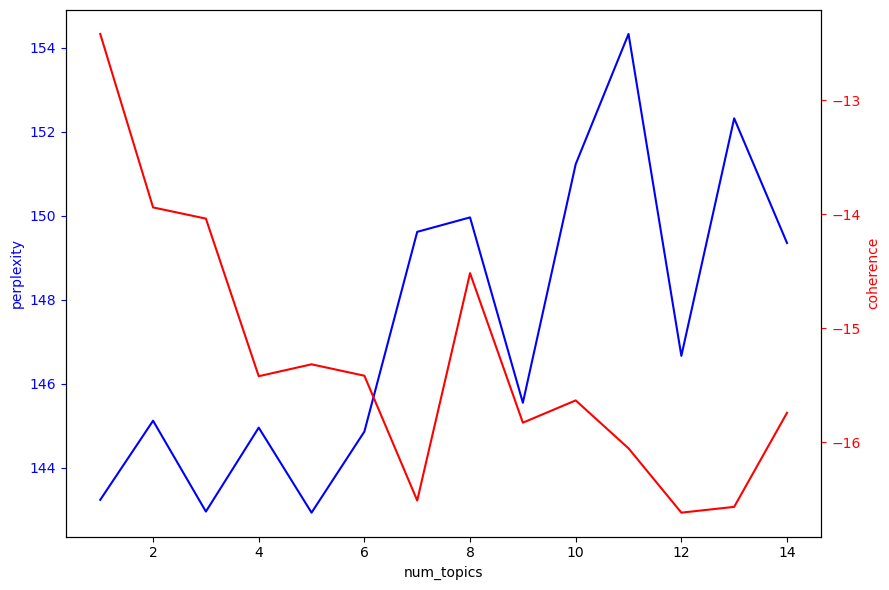

In [6]:
from gensim.models import LdaModel, CoherenceModel
from gensim.test.utils import datapath

perplexity = []
coherence = []
num_topic_range = range(1, 15, 1)

for num_topics in num_topic_range:
    ldamodel = LdaModel(corpus=corpus_,
                        num_topics=num_topics,
                        id2word=dictionary,
                        alpha=0.1,
                        eta=0.1,                   #optional LDAのハイパーパラメータbeta
                        #minimum_probability=0.0    #optional 学習結果に格納するトピック・単語の生起確率の下限
                        )
    pp, ch = compute_metrics(ldamodel, pro_docs, corpus_, dictionary)
    perplexity.append(pp)
    coherence.append(ch)
    # Save model to disk.
    filename = 'model_' + str(num_topics)
    temp_file = datapath(filename)
    ldamodel.save(temp_file)
    
metrics = pd.DataFrame({'num_topic': num_topic_range, 'perplexity': perplexity, 'coherence': coherence})
 
# PerplexityとCoherenceをグラフ化
fig, ax1 = plt.subplots(figsize=(9, 6))
metrics.plot(x='num_topic', y='perplexity', color='b', legend=False, ax=ax1)
ax1.set_xlabel('num_topics')
ax1.set_ylabel('perplexity', color='b')
ax1.tick_params('y', colors='b')
 
ax2 = ax1.twinx()
metrics.plot(x='num_topic', y='coherence', color='r', legend=False, ax=ax2)
ax2.set_ylabel('coherence', color='r')
ax2.tick_params('y', colors='r')
 
fig.tight_layout()
plt.show()

## 最良のトピック数でのLDAモデルをロード

In [7]:
num_topics = 3

# Load a potentially pretrained model from disk.
filename = 'model_' + str(num_topics)
temp_file = datapath(filename)
    
ldamodel = LdaModel.load(temp_file)

## それぞれのトピックの代表キーワードを10個まで示す

In [8]:
# get best 10 keywords for each topic
topics = ldamodel.print_topics(num_words=10)

# create word list
word_list = []
for n, topic in topics:
    word_list.append(re.findall(r'\"(.*?)\"', topics[n][1]))

df = pd.DataFrame(word_list)
df.index = ['topic0','topic1','topic2']
df

,0,1,2,3,4,5,6,7,8,9
topic0,like,love,night,hide,come,sleeve,alone,grow,leaf,mountain
topic1,night,come,love,leaf,long,wind,life,still,though,never
topic2,though,moon,love,world,autumn,life,mount,hear,last,live


## 10個の文章を選んで、それぞれの文書におけるトピック分布を示す

In [12]:
num_topic_range = range(1, 15, 1)
choosen = [0, 10, 23, 37, 42, 53, 64, 71, 81, 98]

for n in range(0, 10):
    # show topic distribution
    print("doc ID "+str(choosen[n])+":" ,end="")
    print(ldamodel.get_document_topics(corpus_[choosen[n]]))
#    print("doc ID "+str(n)+":" ,end="")
#    print(ldamodel.get_document_topics(corpus_[n]))

## for debug
#n=0

#n番目のdocumentのトピック分布
#print(ldamodel.get_document_topics(corpus_[n]))

#n番目のdocumentのcategory
#print(categories[n])

#n番目のdocumentの生の文章
#print(" ".join(docs[n]))

doc ID 0:[(0, 0.98373765)]
doc ID 10:[(0, 0.98692673)]
doc ID 23:[(1, 0.9860122)]
doc ID 37:[(0, 0.010754083), (1, 0.010754283), (2, 0.97849166)]
doc ID 42:[(0, 0.010754677), (1, 0.9784912), (2, 0.010754087)]
doc ID 53:[(0, 0.97848904), (1, 0.010756433), (2, 0.010754495)]
doc ID 64:[(0, 0.98601115)]
doc ID 71:[(2, 0.9849577)]
doc ID 81:[(1, 0.9860109)]
doc ID 98:[(0, 0.010754166), (1, 0.010753223), (2, 0.9784926)]


## 分析

In [13]:
#import pyLDAvis.gensim
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

#全documentを学習に用いた場合結構時間がかかる(20min~)
#gensimではK個のトピックに0~K-1のidが割り振られていたのに対し，pyLDAvisでは1~Kのidが割り振られていることに注意

lda_display = pyLDAvis.gensim_models.prepare(ldamodel, corpus_, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/home/junya/.pyenv/versions/miniconda3-3.7-23.1.0-1/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


## トピック数を変更してその結果を比較

In [17]:
num_topics = 3

# Load a potentially pretrained model from disk.
filename = 'model_' + str(num_topics)
temp_file = datapath(filename)

ldamodel = LdaModel.load(temp_file)

#import pyLDAvis.gensim
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

#全documentを学習に用いた場合結構時間がかかる(20min~)
#gensimではK個のトピックに0~K-1のidが割り振られていたのに対し，pyLDAvisでは1~Kのidが割り振られていることに注意

lda_display = pyLDAvis.gensim_models.prepare(ldamodel, corpus_, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/home/junya/.pyenv/versions/miniconda3-3.7-23.1.0-1/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [18]:
num_topics = 5

# Load a potentially pretrained model from disk.
filename = 'model_' + str(num_topics)
temp_file = datapath(filename)

ldamodel = LdaModel.load(temp_file)

#import pyLDAvis.gensim
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

#全documentを学習に用いた場合結構時間がかかる(20min~)
#gensimではK個のトピックに0~K-1のidが割り振られていたのに対し，pyLDAvisでは1~Kのidが割り振られていることに注意

lda_display = pyLDAvis.gensim_models.prepare(ldamodel, corpus_, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/home/junya/.pyenv/versions/miniconda3-3.7-23.1.0-1/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [19]:
num_topics = 7

# Load a potentially pretrained model from disk.
filename = 'model_' + str(num_topics)
temp_file = datapath(filename)

ldamodel = LdaModel.load(temp_file)

#import pyLDAvis.gensim
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

#全documentを学習に用いた場合結構時間がかかる(20min~)
#gensimではK個のトピックに0~K-1のidが割り振られていたのに対し，pyLDAvisでは1~Kのidが割り振られていることに注意

lda_display = pyLDAvis.gensim_models.prepare(ldamodel, corpus_, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/home/junya/.pyenv/versions/miniconda3-3.7-23.1.0-1/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [20]:
num_topics = 10

# Load a potentially pretrained model from disk.
filename = 'model_' + str(num_topics)
temp_file = datapath(filename)

ldamodel = LdaModel.load(temp_file)

#import pyLDAvis.gensim
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

#全documentを学習に用いた場合結構時間がかかる(20min~)
#gensimではK個のトピックに0~K-1のidが割り振られていたのに対し，pyLDAvisでは1~Kのidが割り振られていることに注意

lda_display = pyLDAvis.gensim_models.prepare(ldamodel, corpus_, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/home/junya/.pyenv/versions/miniconda3-3.7-23.1.0-1/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
